##  Booking.com Reviews

##### Questions:
 This file contains over 515,000 guest reviews and rating of almost 1500 hotels across Europe scraped from popular hotel reservation website Booking.com. The text data was cleaned by removing unicode and punctuation and transformed to lower case. No other preprocessing was done. More information on each field is provided in the "Data Description" tab of the Excel file.

Extending the analysis of this data set from class, you are asked to answer the following questions:

1. What are the top hotel features that guests talk about the most in their Booking.com reviews? Since this is a copy-and-paste from class handout, no points are assigned for this question. (0 point)
2. Score each guest review along each of the above features. Note that features that are not mentioned in a given review should receive no score for that review. You may use the approach discussed in class or a different approach of your choice.
3. Compute the average feature score for each review, and report the correlation between this average score and the “Reviewer_Score” column in the data file. A strong positive correlation (>0.70) would indicate that your scoring mechanism worked. If your correlation was not up to the mark, you may want to explore what you can do to improve it.
4. Compute average feature-wise score for each hotel (across all reviews) and report the correlation between these computed hotel scores and Average_Hotel_Score.
5. Create a dashboard with the following plots: (1) Ten highest rated hotels in Europe (showing your aggregate score and Average_Hotel_Score), (2) Ten highest rated hotels for each of the top five features identified in Question 1.
6. Regress Average_Hotel_Score against the top five feature scores of each hotel, and provide quantitative estimates of how important each feature is for the Average_Hotel_Score.


In [1]:
#Importing packages
import nltk
import pandas as pd
import numpy as np
from textblob import TextBlob, Word
from string import punctuation
from collections import Counter
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.sentiment import SentimentAnalyzer
stopwords = stopwords.words('english')
nltk.download('wordnet')
nltk.download('universal_tagset')
nltk.downloader.download('vader_lexicon')
nltk.downloader.download('vader_lexicon')

import spacy
sp = spacy.load("en_core_web_sm")

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from nltk.sentiment import vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer 

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shradhayadav/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/shradhayadav/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/shradhayadav/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/shradhayadav/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### Data Preprocessing

In [2]:
#Read Data file

df = pd.read_excel(open('/Users/shradhayadav/Documents/Text_Analytics/Data/BookingDotCom_HotelReviews.xlsx','rb')
                   ,  sheet_name='Data')
df.shape

(515738, 12)

In [6]:
df.head()

,Hotel_Name,Hotel_Address,Review_Count,Non_Review_Scoring_Count,Average_Hotel_Score,Review_Date,Reviewer_Nationality,Positive_Review,Negative_Review,Total_Reviewer_Reviews,Reviewer_Score,Tags
0,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-08-03,Russia,Only the park outside of the hotel was beauti...,I am so angry that i made this post available...,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double..."
1,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-08-03,Ireland,No real complaints the hotel was great great ...,No Negative,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double..."
2,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-31,Australia,Location was good and staff were ok It is cut...,Rooms are nice but for elderly a bit difficul...,9,7.1,"[' Leisure trip ', ' Family with young childre..."
3,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-31,United Kingdom,Great location in nice surroundings the bar a...,My room was dirty and I was afraid to walk ba...,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex..."
4,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-24,New Zealand,Amazing location and building Romantic setting,You When I booked with your company on line y...,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St..."


In [3]:
#removing blank reviews if any
df = df.dropna()
df.info

<bound method DataFrame.info of                    Hotel_Name  \
0                 Hotel Arena   
1                 Hotel Arena   
2                 Hotel Arena   
3                 Hotel Arena   
4                 Hotel Arena   
...                       ...   
515733  Atlantis Hotel Vienna   
515734  Atlantis Hotel Vienna   
515735  Atlantis Hotel Vienna   
515736  Atlantis Hotel Vienna   
515737  Atlantis Hotel Vienna   

                                            Hotel_Address  Review_Count  \
0        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...          1403   
1        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...          1403   
2        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...          1403   
3        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...          1403   
4        s Gravesandestraat 55 Oost 1092 AA Amsterdam ...          1403   
...                                                   ...           ...   
515733  Wurzbachgasse 21 15 Rudolfsheim F nfha

##### Top 5 features that customers mention most in positive and negative reviews

Function to extract top 5 adjective-noun pairs from an input Pandas series d

In [4]:
def top_5(df):
    comment_list = df.tolist()                                     # Convert a Pandas series to a list
    comment_list = [c for c in comment_list if pd.isnull(c)==False]
    comment_str  = ' '.join(comment_list)                          # Concatenate all comments to one string
    tokenized = nltk.word_tokenize(comment_str)                    # Tokenize into words
    tokenized = [w for w in tokenized if len(w)>2]
    tagged = nltk.pos_tag(tokenized, tagset='universal')           # Extract POS tags for each word
    bigrams = nltk.bigrams(tagged)                                 # Extract bigrams of POS tagged words
    adj_noun = [(x, y) for x, y in bigrams if x[1]=='ADJ' and y[1]=='NOUN']
    adj_noun = [i[0][0] + ' ' + i[1][0] for i in adj_noun]         # Convert ADJ-NOUN bigram list into a list of strings
    return nltk.FreqDist(adj_noun).most_common(5)                  # Return the 5 most common ADJ-NOUN strings

In [5]:
dfpos = df['Positive_Review'][df['Positive_Review']!="No Positive"].str.lower()
dfneg = df['Negative_Review'][df['Negative_Review']!="No Negative"].str.lower()

In [6]:
top_5(dfpos)

[('great location', 30118),
 ('friendly staff', 24830),
 ('good location', 20316),
 ('helpful staff', 17298),
 ('excellent location', 11561)]

In [56]:
top_5(dfneg)

[('small room', 5682),
 ('double bed', 2353),
 ('double room', 2207),
 ('small rooms', 2098),
 ('hot water', 2060)]

Since top 5 liked features are location, staff, location, staff, and location, and top 5 disliked features are room, bed, room, rooms, and hot water which makes no sense, So we will we try the top 15 positive and negative features

In [57]:
def top_15(df):
    comment_list = df.tolist()                                      # Convert a Pandas series to a list
    comment_list = [c for c in comment_list if pd.isnull(c)==False]
    comment_str  = ' '.join(comment_list)                          # Concatenate all comments to one string
    tokenized = nltk.word_tokenize(comment_str)                    # Tokenize into words
    tokenized = [w for w in tokenized if len(w)>2]
    tagged = nltk.pos_tag(tokenized, tagset='universal')           # Extract POS tags for each word
    bigrams = nltk.bigrams(tagged)                                 # Extract bigrams of POS tagged words
    adj_noun = [(x, y) for x, y in bigrams if x[1]=='ADJ' and y[1]=='NOUN']
    adj_noun = [i[0][0] + ' ' + i[1][0] for i in adj_noun]         # Convert ADJ-NOUN bigram list into a list of strings
    return nltk.FreqDist(adj_noun).most_common(15)                  # Return the 5 most common ADJ-NOUN strings

In [59]:
top_15(dfpos)

[('great location', 30118),
 ('friendly staff', 24830),
 ('good location', 20316),
 ('helpful staff', 17298),
 ('excellent location', 11561),
 ('good breakfast', 8920),
 ('comfortable bed', 7299),
 ('comfortable room', 5158),
 ('perfect location', 5120),
 ('great staff', 4956),
 ('clean room', 4782),
 ('good value', 4488),
 ('great breakfast', 4415),
 ('nice staff', 3865),
 ('excellent staff', 3646)]

In [18]:
top_15(dfneg)

[('small room', 535),
 ('double bed', 248),
 ('double room', 239),
 ('little bit', 208),
 ('small rooms', 196),
 ('hot water', 166),
 ('next day', 164),
 ('next door', 158),
 ('star hotel', 150),
 ('only thing', 149),
 ('first night', 142),
 ('single room', 137),
 ('single beds', 135),
 ('free wifi', 123),
 ('other rooms', 122)]

##### Q1: What are the top hotel features that guests talk about the most in their Booking.com reviews? Since this is a copy-and-paste from class handout, no points are assigned for this question.

Based on manual inspection of the top 15 results, the top 5 features customers like most are: (1) location, (2) staff helpfulness/friendliness, (3) breakfast quality, (4) bed, and (5) value (amenities commensurate with cost).The top 5 negative features that customers dislike most are: (1) room size, (2) not having hot water (?), (3) not having free wifi (?), (4) ??? and (5) ???. So even top 15 wasn't enough. Perhaps try top 25.


#### Question 2- Score each guest review along each of the above features. Note that features that are not mentioned in a given review should receive no score for that review. You may use the approach discussed in class or a different approach of your choice.

#### Feature Extraction and Scoring

In [60]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [67]:
def top_10_nouns(df):
    comment_list = df.tolist()
    comment_list = [c for c in comment_list if pd.isnull(c)==False]
    comment_str  = ' '.join(comment_list) 
    words = nltk.word_tokenize(comment_str) 
    words = [w for w in words if len(w)>2]
    words = [lemmatizer.lemmatize(w) for w in words]
    tagged = nltk.pos_tag(words, tagset='universal')
    nouns = [w[0] for w in tagged if w[1]=='NOUN']
    return nltk.FreqDist(nouns).most_common(10) 

In [64]:
top_10_nouns(dfpos)

[('staff', 196634),
 ('location', 191641),
 ('room', 181116),
 ('wa', 133273),
 ('hotel', 128633),
 ('breakfast', 80076),
 ('bed', 46446),
 ('station', 32140),
 ('service', 27260),
 ('everything', 27137)]

In [23]:
top_10_nouns(dfneg)

[('room', 20283),
 ('wa', 11794),
 ('hotel', 7694),
 ('breakfast', 5211),
 ('nothing', 3814),
 ('staff', 3735),
 ('night', 2792),
 ('bed', 2716),
 ('bathroom', 2619),
 ('time', 2292)]

Top features mentioned in positive comments are: (1) staff, (2) location, (3) room (size? amenities?), (4) breakfast, (5) service (room service? staff service?). Top features mentioned in negative comments are: (1) room, (2) breakfast, (3) staff, (4) bed, (5) bathroom. Combining both lists, the features hotel customers care most about are: (1) room, (2) staff, (3) location, (4) breakfast, (5) bed, and (6) bathroom. 

In [14]:
features = ['room', 'staff', 'location', 'breakfast', 'bed', 'bathroom']

In [10]:
#Since Processing is taking longer then expected,running sample data
d= df.sample(n=1000)
d.shape

(1000, 12)

In [11]:
#updating values in Review having no comments
for i in d.index:
    if d['Positive_Review'][i]=="No Positive":
        d.loc[i,'Positive_Review'] = "N/a"

    if d['Negative_Review'][i]=="No Negative" :
        d.loc[i,'Negative_Review'] = "N/a"



In [15]:
P_review=[]
N_review=[]
reviews=[]

df_Score = pd.DataFrame()
for i in d.index:
    P_review = d['Positive_Review'][i]
    P_review = str(P_review).strip()        #removing trailing and leading spaces)
    N_review = d['Negative_Review'][i]
    N_review = str(P_review).strip() 
    Hotel_Name = d['Hotel_Name'][i]
    Reviewer_Score = d['Reviewer_Score'][i]
    Average_Hotel_Score = d['Average_Hotel_Score'][i]
   

    #tokenizing reviews by Capital character after appending period, assuming new sentence starting with Capital
    #updating any word in upper to lower to keep uniform capitalize case
    #concatenating positive & Negative reviews for each reviewer by period and tehn tokenizing
    
    
    if  P_review.islower() or N_review.isupper(): 
        P_review = P_review.capitalize()
    if  N_review.islower() or N_review.isupper():
        N_review = N_review.capitalize()
   
    P_split = P_review.split()
    for i in range(len(P_split)):
        if len(P_split[i])> 2 and P_split[i].isupper():
            P_split[i] = P_split[i].lower()

    N_split = N_review.split()
    for i in range(len(N_split)):
        if len(N_split[i])> 2 and N_split[i].isupper():
            N_split[i] = N_split[i].lower()
           
    P_review = ' '.join(P_split)
    N_review = ' '.join(N_split)
    review = P_review + '.' + N_review
   
    regex = re.sub( r"([A-Z]\w+[a-z])", r".\1", review)
    merged_review = regex.split('.')
   
    for m in merged_review:
        if m == ' ' or m=='':
            merged_review.remove(m)

           
    for m in merged_review:
        reviews.append(m)
        for f in features:
            if f in m:
                polarity_score = []
                analyzer = SentimentIntensityAnalyzer()
                p = analyzer.polarity_scores(m)
                polarity_score = (p['compound'])

                # Recording all tokenized senetences, respective features and each sentence polarity 
                # against each reviewer in dataframe df_Score 
    
                feature_score_temp = pd.DataFrame({'d_Index':[i], 'Hotel_Name':Hotel_Name
                                                   ,'Review':review,'Review_sent':m,'Feature':f
                                                   ,'Polarity_Score': polarity_score,'Reviewer_Score': Reviewer_Score
                                                   ,'Average_Hotel_Score': Average_Hotel_Score
                                                  })
                df_Score = pd.concat([df_Score,feature_score_temp])


                                                                                        
df_Score=df_Score.drop(['d_Index'],axis=1)
df_Score.reset_index(drop=True, inplace=True) 
df_Score


  

,Hotel_Name,Review,Review_sent,Feature,Polarity_Score,Reviewer_Score,Average_Hotel_Score
0,Atahotel Linea Uno,Breakfast is great and our room is big and ver...,Breakfast is great and our room is big and ver...,room,0.7960,9.6,8.0
1,Atahotel Linea Uno,Breakfast is great and our room is big and ver...,Breakfast is great and our room is big and ver...,room,0.7960,9.6,8.0
2,Best Western Plus Hotel Blue Square,The staff is so helpful Rooms are clean with n...,The staff is so helpful,staff,0.5598,9.2,7.3
3,Best Western Plus Hotel Blue Square,The staff is so helpful Rooms are clean with n...,The staff is so helpful,staff,0.5598,9.2,7.3
4,Strand Palace Hotel,Excellent breakfast Very pleasant staff.Excell...,Excellent breakfast,breakfast,0.5719,10.0,8.1
...,...,...,...,...,...,...,...
2345,Villa Beaumarchais,Villa Beaumarchais is a fine hotel In a world ...,Staff was extremely friendly and managed well ...,room,0.6801,7.9,8.1
2346,Qualys Hotel Nasco,Great location for conference at MiCo Very fri...,Great location for conference at,location,0.6249,9.2,8.2
2347,Qualys Hotel Nasco,Great location for conference at MiCo Very fri...,Very friendly staff,staff,0.5413,9.2,8.2
2348,Qualys Hotel Nasco,Great location for conference at MiCo Very fri...,Great location for conference at,location,0.6249,9.2,8.2


In [16]:
#Compute mean polarity of each feature in each review. These mean polarities are feature-wise rating.

df_featurewise_rating= pd.DataFrame()
df_featurewise_rating = df_Score.groupby(['Hotel_Name','Review','Feature']).mean('Polarity_Score')
df_featurewise_rating = df_featurewise_rating.rename(columns = {'Polarity_Score':'FeatureWise_Rating' })
df_featurewise_rating = df_featurewise_rating.reset_index()
df_featurewise_rating

,Hotel_Name,Review,Feature,FeatureWise_Rating,Reviewer_Score,Average_Hotel_Score
0,88 Studios,Comfortable beds big bathroom nice shower kitc...,bathroom,0.8442,10.0,8.4
1,88 Studios,Comfortable beds big bathroom nice shower kitc...,bed,0.8442,10.0,8.4
2,88 Studios,Comfortable beds big bathroom nice shower kitc...,room,0.8442,10.0,8.4
3,Ace Hotel London Shoreditch,Great bathroom Friendly staff.Great bathroom F...,bathroom,0.6249,7.9,8.6
4,Ace Hotel London Shoreditch,Great bathroom Friendly staff.Great bathroom F...,room,0.6249,7.9,8.6
...,...,...,...,...,...,...
1117,citizenM London Shoreditch,The bed was very comfortable good shower and t...,bed,0.7764,6.7,9.1
1118,citizenM London Shoreditch,The bed was very comfortable good shower and t...,room,0.7764,6.7,9.1
1119,citizenM Tower of London,Everything staff adorable place immaculate Rea...,staff,0.4939,9.6,9.1
1120,citizenM Tower of London,The location is really amazing that through th...,location,0.6240,10.0,9.1


In [17]:
#Compute Feature-wise Score for each Hotel
df_Hotel_FeatureScore=pd.DataFrame()
df_Hotel_FeatureScore = df_Score.drop(['Reviewer_Score'], axis=1)
df_Hotel_FeatureScore = df_Hotel_FeatureScore.groupby(['Hotel_Name','Feature']).mean('Polarity_Score')
df_Hotel_FeatureScore = df_Hotel_FeatureScore.rename(columns = {'Polarity_Score':'FeatureWise_Score' })
df_Hotel_FeatureScore = df_Hotel_FeatureScore.reset_index()
df_Hotel_FeatureScore

,Hotel_Name,Feature,FeatureWise_Score,Average_Hotel_Score
0,88 Studios,bathroom,0.84420,8.4
1,88 Studios,bed,0.84420,8.4
2,88 Studios,room,0.84420,8.4
3,Ace Hotel London Shoreditch,bathroom,0.62490,8.6
4,Ace Hotel London Shoreditch,room,0.62490,8.6
...,...,...,...,...
936,citizenM London Shoreditch,room,0.75945,9.1
937,citizenM London Shoreditch,staff,0.80160,9.1
938,citizenM Tower of London,location,0.62400,9.1
939,citizenM Tower of London,staff,0.49390,9.1


#### Question 3. Compute the average feature score for each review, and report the correlation between this average score and the “Reviewer_Score” column in the data file. A strong positive correlation (>0.70) would indicate that your scoring mechanism worked. If your correlation was not up to the mark, you may want to explore what you can do to improve it.

In [18]:
#Compute the average feature score for each review
df_feature_Score= pd.DataFrame()
df_feature_Score = df_featurewise_rating.groupby(['Hotel_Name','Review']).mean('FeatureWise_Rating')
df_feature_Score = df_feature_Score.rename(columns = {'FeatureWise_Rating':'Avg_Feature_Score' })
df_feature_Score = df_feature_Score.reset_index()
df_feature_Score

,Hotel_Name,Review,Avg_Feature_Score,Reviewer_Score,Average_Hotel_Score
0,88 Studios,Comfortable beds big bathroom nice shower kitc...,0.844200,10.0,8.4
1,Ace Hotel London Shoreditch,Great bathroom Friendly staff.Great bathroom F...,0.581233,7.9,8.6
2,Ace Hotel London Shoreditch,The staff were great I thought we might be a l...,0.847700,8.8,8.6
3,Acta CITY47,Great location near the train station but on a...,0.371600,10.0,8.1
4,Aloft London Excel,Really comfortable beds Pool and gym were exce...,0.556300,10.0,8.7
...,...,...,...,...,...
626,citizenM London Shoreditch,Love Spitalfields so this was a good location ...,0.487700,8.8,9.1
627,citizenM London Shoreditch,The bed was very comfortable good shower and t...,0.776400,6.7,9.1
628,citizenM Tower of London,Everything staff adorable place immaculate Rea...,0.493900,9.6,9.1
629,citizenM Tower of London,The location is really amazing that through th...,0.624000,10.0,9.1


In [19]:
#correlation between this average score and the “Reviewer_Score”
Avg_Feature_Score = df_feature_Score['Avg_Feature_Score']
Reviewer_Score = df_feature_Score['Reviewer_Score']
correlation = Avg_Feature_Score.corr(Reviewer_Score)
correlation

0.21899929329633863

#### Question 4. Compute average feature-wise score for each hotel (across all reviews) and report the correlation between these computed hotel scores and Average_Hotel_Score.


In [20]:
#Compute average feature-wise score for each hotel (across all reviews)
df_Hotel_Score = pd.DataFrame()
df_Hotel_Score= df_Hotel_FeatureScore.groupby(['Hotel_Name']).mean('FeatureWise_Score')
df_Hotel_Score = df_Hotel_Score.rename(columns = {'FeatureWise_Score':'Avg_FeatureWise_Score' })
df_Hotel_Score  = df_Hotel_Score.reset_index()
df_Hotel_Score

,Hotel_Name,Avg_FeatureWise_Score,Average_Hotel_Score
0,88 Studios,0.844200,8.4
1,Ace Hotel London Shoreditch,0.640200,8.6
2,Acta CITY47,0.371600,8.1
3,Aloft London Excel,0.556300,8.7
4,Amadi Panorama Hotel,0.532900,8.4
...,...,...,...
414,citizenM Amsterdam,0.778083,8.6
415,citizenM London Bankside,0.197567,9.1
416,citizenM London Shoreditch,0.745525,9.1
417,citizenM Tower of London,0.558950,9.1


In [21]:
#correlation between this average feature-wise score and the “Average_Hotel_Score” for each hotel
Avg_FeatureWise_Score = df_Hotel_Score['Avg_FeatureWise_Score']
Average_Hotel_Score = df_Hotel_Score['Average_Hotel_Score']
correlation = Avg_FeatureWise_Score.corr(Average_Hotel_Score)
correlation

0.039285572665376495

#### Question 5. Create a dashboard with the following plots: (1) Ten highest rated hotels in Europe (showing your aggregate score and Average_Hotel_Score), (2) Ten highest rated hotels for each of the top five features identified in Question 1.


In [22]:
#(1) Ten highest rated hotels in Europe (showing your aggregate score and Average_Hotel_Score),

df_Hotel_Score = df_Hotel_Score.set_index(df_Hotel_Score.index)
df_Hotel_Score = df_Hotel_Score.sort_values(by='Average_Hotel_Score', ascending=False)
df_High_Rated_Hotel_Score = df_Hotel_Score.head(10)
df_High_Rated_Hotel_Score = df_High_Rated_Hotel_Score.reset_index()
df_High_Rated_Hotel_Score

,index,Hotel_Name,Avg_FeatureWise_Score,Average_Hotel_Score
0,322,Ritz Paris,0.000000,9.8
1,111,H10 Casa Mimosa 4 Sup,0.848100,9.6
2,51,Charlotte Street Hotel,0.904200,9.5
3,202,Intercontinental London The O2,0.836037,9.4
4,389,The Savoy,0.729800,9.4
5,177,Hotel Palace GL,0.000000,9.4
6,378,The One Barcelona GL,0.718400,9.4
7,272,Nolinski Paris,0.622000,9.4
8,7,Ambassade Hotel,0.777800,9.3
9,286,Olivia Balmes Hotel,0.744400,9.3


In [23]:
colors = {'Avg_FeatureWise_Score' :'Orange'
          ,'Average_Hotel_Score': 'Blue'}
x_label  = df_High_Rated_Hotel_Score['Hotel_Name'].tolist()
y1_label = df_High_Rated_Hotel_Score['Avg_FeatureWise_Score'].tolist()
y2_label = df_High_Rated_Hotel_Score['Average_Hotel_Score'].tolist()
y_label=[]
for i in y1_label:
    i = round(i,2)
#     print(i)
    y_label.append(i)
print(y_label)

[0.0, 0.85, 0.9, 0.84, 0.73, 0.0, 0.72, 0.62, 0.78, 0.74]


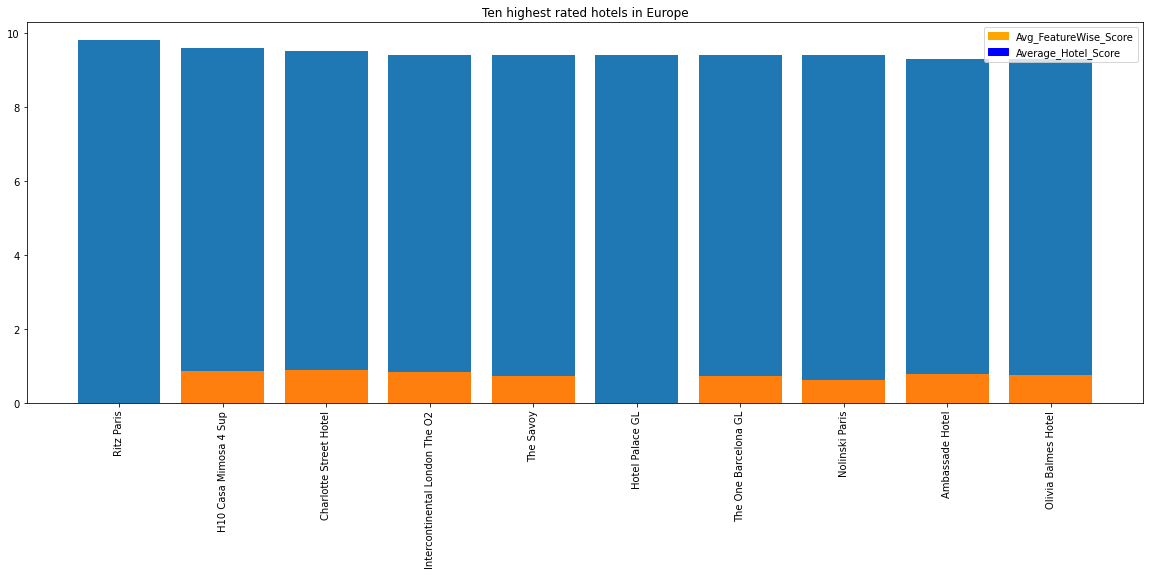

In [24]:
import matplotlib.pyplot as plot
fig, ax = plot.subplots(figsize=(20,7))
ax.bar(x_label,y2_label)
ax.bar(x_label,y_label)
labels = (colors.keys())
handles = [plot.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plot.legend(handles, labels)
plot.xticks(rotation = 90)
plot.title('Ten highest rated hotels in Europe')
plot.show()
# X = np.arange(10)
# plot.bar(x_label, d[1], color = 'b', width = 0.25)
# plot.bar(x_label, d[2], color = 'g', width = 0.25)

#(2) Ten highest rated hotels for each of the top five features identified in Question 1.


In [25]:
df_Hotel_FeatureScore

,Hotel_Name,Feature,FeatureWise_Score,Average_Hotel_Score
0,88 Studios,bathroom,0.84420,8.4
1,88 Studios,bed,0.84420,8.4
2,88 Studios,room,0.84420,8.4
3,Ace Hotel London Shoreditch,bathroom,0.62490,8.6
4,Ace Hotel London Shoreditch,room,0.62490,8.6
...,...,...,...,...
936,citizenM London Shoreditch,room,0.75945,9.1
937,citizenM London Shoreditch,staff,0.80160,9.1
938,citizenM Tower of London,location,0.62400,9.1
939,citizenM Tower of London,staff,0.49390,9.1


In [26]:
df_Hotel_FeatureScore['Feature_Room_Score']=''
df_Hotel_FeatureScore['Feature_Bed_Score']=''
df_Hotel_FeatureScore['Feature_Location_Score']=''
df_Hotel_FeatureScore['Feature_Bathroom_Score']=''
df_Hotel_FeatureScore['Feature_Staff_Score']=''
df_Hotel_FeatureScore['Feature_Breakfast_Score']=''
df_Hotel_FeatureScore

,Hotel_Name,Feature,FeatureWise_Score,Average_Hotel_Score,Feature_Room_Score,Feature_Bed_Score,Feature_Location_Score,Feature_Bathroom_Score,Feature_Staff_Score,Feature_Breakfast_Score
0,88 Studios,bathroom,0.84420,8.4,,,,,,
1,88 Studios,bed,0.84420,8.4,,,,,,
2,88 Studios,room,0.84420,8.4,,,,,,
3,Ace Hotel London Shoreditch,bathroom,0.62490,8.6,,,,,,
4,Ace Hotel London Shoreditch,room,0.62490,8.6,,,,,,
...,...,...,...,...,...,...,...,...,...,...
936,citizenM London Shoreditch,room,0.75945,9.1,,,,,,
937,citizenM London Shoreditch,staff,0.80160,9.1,,,,,,
938,citizenM Tower of London,location,0.62400,9.1,,,,,,
939,citizenM Tower of London,staff,0.49390,9.1,,,,,,


In [27]:
df_Hotel_FeatureScore = df_Hotel_FeatureScore.assign(Feature_Room_Score=(df_Hotel_FeatureScore.FeatureWise_Score).where(df_Hotel_FeatureScore.Feature == 'room',0))    
df_Hotel_FeatureScore = df_Hotel_FeatureScore.assign(Feature_Bed_Score=(df_Hotel_FeatureScore.FeatureWise_Score).where(df_Hotel_FeatureScore.Feature == 'bed',0))
df_Hotel_FeatureScore = df_Hotel_FeatureScore.assign(Feature_Location_Score=(df_Hotel_FeatureScore.FeatureWise_Score).where(df_Hotel_FeatureScore.Feature == 'location',0))
df_Hotel_FeatureScore = df_Hotel_FeatureScore.assign(Feature_Bathroom_Score=(df_Hotel_FeatureScore.FeatureWise_Score).where(df_Hotel_FeatureScore.Feature == 'bathroom',0))
df_Hotel_FeatureScore = df_Hotel_FeatureScore.assign(Feature_Staff_Score=(df_Hotel_FeatureScore.FeatureWise_Score).where(df_Hotel_FeatureScore.Feature == 'staff',0))
df_Hotel_FeatureScore = df_Hotel_FeatureScore.assign(Feature_Breakfast_Score=(df_Hotel_FeatureScore.FeatureWise_Score).where(df_Hotel_FeatureScore.Feature == 'breakfast',0))
df_Hotel_FeatureScore

,Hotel_Name,Feature,FeatureWise_Score,Average_Hotel_Score,Feature_Room_Score,Feature_Bed_Score,Feature_Location_Score,Feature_Bathroom_Score,Feature_Staff_Score,Feature_Breakfast_Score
0,88 Studios,bathroom,0.84420,8.4,0.00000,0.0000,0.000,0.8442,0.0000,0.0
1,88 Studios,bed,0.84420,8.4,0.00000,0.8442,0.000,0.0000,0.0000,0.0
2,88 Studios,room,0.84420,8.4,0.84420,0.0000,0.000,0.0000,0.0000,0.0
3,Ace Hotel London Shoreditch,bathroom,0.62490,8.6,0.00000,0.0000,0.000,0.6249,0.0000,0.0
4,Ace Hotel London Shoreditch,room,0.62490,8.6,0.62490,0.0000,0.000,0.0000,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...
936,citizenM London Shoreditch,room,0.75945,9.1,0.75945,0.0000,0.000,0.0000,0.0000,0.0
937,citizenM London Shoreditch,staff,0.80160,9.1,0.00000,0.0000,0.000,0.0000,0.8016,0.0
938,citizenM Tower of London,location,0.62400,9.1,0.00000,0.0000,0.624,0.0000,0.0000,0.0
939,citizenM Tower of London,staff,0.49390,9.1,0.00000,0.0000,0.000,0.0000,0.4939,0.0


In [28]:
df_Hotel = pd.DataFrame()
df_Hotel = df_Hotel_FeatureScore.groupby(['Hotel_Name']).mean({'Feature_Room_Score','Feature_Bed_Score'
                                                               ,'Feature_Location_Score','Feature_Bathroom_Score'
                                                              ,'Feature_Staff_Score','Feature_Breakfast_Score'})

df_Hotel = df_Hotel.reset_index()
df_Hotel

,Hotel_Name,FeatureWise_Score,Average_Hotel_Score,Feature_Room_Score,Feature_Bed_Score,Feature_Location_Score,Feature_Bathroom_Score,Feature_Staff_Score,Feature_Breakfast_Score
0,88 Studios,0.844200,8.4,0.281400,0.281400,0.000000,0.2814,0.000000,0.000000
1,Ace Hotel London Shoreditch,0.640200,8.6,0.208300,0.000000,0.000000,0.2083,0.223600,0.000000
2,Acta CITY47,0.371600,8.1,0.000000,0.000000,0.371600,0.0000,0.000000,0.000000
3,Aloft London Excel,0.556300,8.7,0.000000,0.556300,0.000000,0.0000,0.000000,0.000000
4,Amadi Panorama Hotel,0.532900,8.4,0.000000,0.000000,0.285950,0.0000,0.246950,0.000000
...,...,...,...,...,...,...,...,...,...
414,citizenM Amsterdam,0.778083,8.6,0.000000,0.185433,0.000000,0.0000,0.301417,0.291233
415,citizenM London Bankside,0.197567,9.1,0.197567,0.000000,0.000000,0.0000,0.000000,0.000000
416,citizenM London Shoreditch,0.745525,9.1,0.189863,0.194100,0.161163,0.0000,0.200400,0.000000
417,citizenM Tower of London,0.558950,9.1,0.000000,0.000000,0.312000,0.0000,0.246950,0.000000


In [29]:
d_room =df_Hotel.sort_values(by= 'Feature_Room_Score', ascending=False)
d_room = d_room.head(10)
top_rated_hotel_room = d_room['Hotel_Name'].tolist()

#### Question 6. Regress Average_Hotel_Score against the top five feature scores of each hotel, and provide quantitative estimates of how important each feature is for the Average_Hotel_Score.


In [ ]:
df_Score
#Compute Feature-wise Score for each Hotel
# df_Hotel_FeatScore=pd.DataFrame()
# df_Hotel_FeatScore = df_Score.drop(['Reviewer_Score'], axis=1)
# df_Hotel_FeatScore = df_Hotel_FeatScore.groupby(['Hotel_Name','Feature']).mean('Polarity_Score')
# df_Hotel_FeatScore = df_Hotel_FeatScore.rename(columns = {'Polarity_Score':'FeatureWise_Score' })
# df_Hotel_FeatScore = df_Hotel_FeatScore.reset_index()
# df_Hotel_FeatScore